# Wage Gap Prediction

## Data preparation and cleaning

## 1 Import Python Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sklearn
import matplotlib.pyplot as plt
import sklearn.preprocessing as sp
import statsmodels.api as sm
from  sklearn import feature_selection 
from sklearn import linear_model
from sklearn import metrics
from pandas.stats.api import ols

## 2 Load CSVs

In [2]:
gender_data_raw = pd.read_csv('working_data\GenderStat_Data_new.csv',header=None,skiprows=0)

payment_gap_oecd_raw = pd.read_csv('working_data\Payment_gap_oecd.csv', header=None,skiprows = 1)
payment_gap_oecd_raw.head(10)

,0,1,2,3,4,5,6,7
0,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1975,21.582733,Australia
1,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1976,20.754717,Australia
2,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1977,18.390804,Australia
3,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1978,19.791666,Australia
4,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1979,20.000000,Australia
5,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1980,18.750000,Australia
6,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1981,18.253969,Australia
7,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1982,20.819113,Australia
8,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1983,19.155844,Australia
9,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1984,18.674698,Australia


## 3 Travers years and indicator in GenderStats

In [3]:
gender_data_raw.drop(gender_data_raw.columns[[1,3]], axis=1, inplace=True)
gender_data_raw.loc[0,0] = 'country-full-name'

gender_data_raw.columns = gender_data_raw.loc[0]

gender_data_raw = pd.pivot_table(gender_data_raw,index ='country-full-name', columns='Indicator Name')

gender_data_raw = gender_data_raw.stack(level=0)
gender_data_raw.reset_index(inplace=True)
gender_data_raw.rename(columns={0:'Year'},inplace=True)
gender_data_raw.rename(columns={"Indicator Name":'Id'},inplace=True)
gender_data_raw.to_csv("TempCsv.csv")

gender_stats_normalized = pd.read_csv("TempCsv.csv")
gender_stats_normalized.drop(gender_stats_normalized.columns[[0]], axis=1, inplace=True)
gender_stats_normalized.head()

,country-full-name,Year,"Access to anti-retroviral drugs, female (%)","Access to anti-retroviral drugs, male (%)","Account at a financial institution, female (% age 15+) [ts]","Account at a financial institution, male (% age 15+) [ts]","Adolescent fertility rate (births per 1,000 women ages 15-19)","Age at first marriage, female","Age at first marriage, male",Age dependency ratio (% of working-age population),...,Women who own land both alone and jointly (% of women age 15-49): Q3,Women who own land both alone and jointly (% of women age 15-49): Q4,Women who own land both alone and jointly (% of women age 15-49): Q5 (highest),Women who own land jointly (% of women age 15-49),Women who own land jointly (% of women age 15-49): Q1 (lowest),Women who own land jointly (% of women age 15-49): Q2,Women who own land jointly (% of women age 15-49): Q3,Women who own land jointly (% of women age 15-49): Q4,Women who own land jointly (% of women age 15-49): Q5 (highest),Women who were first married by age 18 (% of women ages 20-24)
0,Australia,1960.0,NaN,NaN,NaN,NaN,44.8286,NaN,NaN,63.356535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Australia,1961.0,NaN,NaN,NaN,NaN,45.0668,NaN,NaN,63.596913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Australia,1962.0,NaN,NaN,NaN,NaN,45.3050,NaN,NaN,63.372475,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Australia,1963.0,NaN,NaN,NaN,NaN,45.9764,NaN,NaN,62.857899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Australia,1964.0,NaN,NaN,NaN,NaN,46.6478,NaN,NaN,62.304998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4 Adding Header to Data Files and removing duplicates from OECD csv

In [4]:
payment_gap_oecd_raw.columns = ['location', 'indicator', 'subject', 'measure', 'frequency', 'Year', 'WageGaP', 'country-full-name']

#removing duplicate values for the same year in the OECD csv
payment_gap_oecd_raw = payment_gap_oecd_raw[payment_gap_oecd_raw['subject'] == 'TOT']

## 5 Intersect Countries and merge two csv's

In [5]:
#checking both csv's - country-full-name
#csv's - gender_stats_normalized, payment_gap_oecd_raw
new_data_raw = pd.merge(gender_stats_normalized, payment_gap_oecd_raw, how='inner', on=['country-full-name', 'Year'])
new_data_raw.head(10)

,country-full-name,Year,"Access to anti-retroviral drugs, female (%)","Access to anti-retroviral drugs, male (%)","Account at a financial institution, female (% age 15+) [ts]","Account at a financial institution, male (% age 15+) [ts]","Adolescent fertility rate (births per 1,000 women ages 15-19)","Age at first marriage, female","Age at first marriage, male",Age dependency ratio (% of working-age population),...,Women who own land jointly (% of women age 15-49): Q3,Women who own land jointly (% of women age 15-49): Q4,Women who own land jointly (% of women age 15-49): Q5 (highest),Women who were first married by age 18 (% of women ages 20-24),location,indicator,subject,measure,frequency,WageGaP
0,Australia,1975.0,NaN,NaN,NaN,NaN,38.5016,NaN,NaN,56.816075,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,21.582733
1,Australia,1976.0,NaN,NaN,NaN,NaN,35.1688,22.0,24.4,56.478399,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,20.754717
2,Australia,1977.0,NaN,NaN,NaN,NaN,31.8360,NaN,NaN,55.782389,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,18.390804
3,Australia,1978.0,NaN,NaN,NaN,NaN,30.6870,NaN,NaN,54.923225,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,19.791666
4,Australia,1979.0,NaN,NaN,NaN,NaN,29.5380,NaN,NaN,54.143916,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,20.000000
5,Australia,1980.0,NaN,NaN,NaN,NaN,28.3890,NaN,NaN,53.550174,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,18.750000
6,Australia,1981.0,NaN,NaN,NaN,NaN,27.2400,23.5,25.7,52.703024,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,18.253969
7,Australia,1982.0,NaN,NaN,NaN,NaN,26.0910,NaN,NaN,52.204834,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,20.819113
8,Australia,1983.0,NaN,NaN,NaN,NaN,25.0928,NaN,NaN,51.904419,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,19.155844
9,Australia,1984.0,NaN,NaN,NaN,NaN,24.0946,NaN,NaN,51.574265,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,18.674698


## 6 Drop unnecessary columns remove rows with too many NANs

In [6]:
new_data_raw.drop('subject', axis=1, inplace=True)
new_data_raw.drop('indicator', axis=1, inplace=True)
new_data_raw.drop('location', axis=1, inplace=True)
new_data_raw.drop('frequency', axis=1, inplace=True)
new_data_raw.drop('measure', axis=1, inplace=True)

#thresh is the minimum number of non NAN values
new_data_raw = new_data_raw.dropna(1,thresh = new_data_raw.shape[0] * 90 / 100)

## 7 Add Convert country-full-name columns to binary columns

In [7]:
cols = new_data_raw.columns.tolist()
cols_to_transform = [cols[0]]
binary_countries = pd.get_dummies(data = new_data_raw,columns=cols_to_transform)
countries = set(new_data_raw['country-full-name'])
countries_count = len(countries)

cols = binary_countries.columns.tolist()
cols = cols[-countries_count:] + cols[:-countries_count]
binary_countries = binary_countries[cols]
binary_countries.to_csv("Binary.csv")
binary_countries.head()

,country-full-name_Australia,country-full-name_Austria,country-full-name_Belgium,country-full-name_Canada,country-full-name_Chile,country-full-name_Czech Republic,country-full-name_Denmark,country-full-name_Estonia,country-full-name_Finland,country-full-name_France,...,"Self-employed, male (% of males employed)","Unemployment, female (% of female labor force) (national estimate)","Unemployment, male (% of male labor force) (national estimate)","Unemployment, total (% of total labor force) (national estimate)","Unemployment, youth female (% of female labor force ages 15-24) (national estimate)","Unemployment, youth male (% of male labor force ages 15-24) (national estimate)","Unemployment, youth total (% of total labor force ages 15-24) (national estimate)","Wage and salaried workers, female (% of females employed)","Wage and salary workers, male (% of males employed)",WageGaP
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.582733
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.754717
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.390804
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.791666
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.000000


## 8 Specifying Data Types

In [8]:
new_data_raw = binary_countries
cols = binary_countries.columns.tolist()
binary_variables = cols[0:countries_count]
numeric_variables = cols[countries_count:]

## 9 Type Conversion - convert all fearutes to float and countries to binaries

In [9]:
for variable in binary_variables:
    new_data_raw[variable] = new_data_raw[variable].astype(np.int)
new_data_raw[binary_variables].dtypes
new_data_raw.head()

,country-full-name_Australia,country-full-name_Austria,country-full-name_Belgium,country-full-name_Canada,country-full-name_Chile,country-full-name_Czech Republic,country-full-name_Denmark,country-full-name_Estonia,country-full-name_Finland,country-full-name_France,...,"Self-employed, male (% of males employed)","Unemployment, female (% of female labor force) (national estimate)","Unemployment, male (% of male labor force) (national estimate)","Unemployment, total (% of total labor force) (national estimate)","Unemployment, youth female (% of female labor force ages 15-24) (national estimate)","Unemployment, youth male (% of male labor force ages 15-24) (national estimate)","Unemployment, youth total (% of total labor force ages 15-24) (national estimate)","Wage and salaried workers, female (% of females employed)","Wage and salary workers, male (% of males employed)",WageGaP
0,1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.582733
1,1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.754717
2,1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.390804
3,1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.791666
4,1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.000000


## 11 Impute Missing Values

In [10]:
data_no_na = new_data_raw
cols = data_no_na.columns.tolist()
imputed_variables = cols[countries_count+1:]
for variable in imputed_variables:
    data_no_na[variable].fillna(method='ffill', inplace=True)
    data_no_na[variable].fillna(method='bfill', inplace=True)

## 12 Vizualization

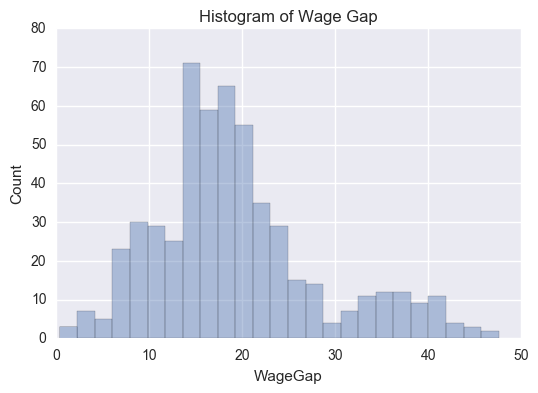

In [11]:
%matplotlib inline
sns.distplot(data_no_na.WageGaP, bins = 25, kde = False)
plt.title('Histogram of Wage Gap')
plt.xlabel('WageGap')
plt.ylabel('Count')
data_no_na.to_csv('data.csv')

## 13 split to X and y

In [12]:
x = data_no_na[list(data_no_na)[:-1]]

split y to train and test by year

In [13]:
traintest_threshold = 2008
y_train = data_no_na[data_no_na['Year'] < traintest_threshold ]
y_train = y_train['WageGaP']

y_test = data_no_na[data_no_na['Year'] >= traintest_threshold ]
y_test = y_test['WageGaP']

## 14 Normelize all values in x

In [14]:
l = list(data_no_na)
x_normelize = pd.DataFrame(sp.MinMaxScaler().fit_transform(data_no_na),columns = l)
x_normelize.drop('WageGaP', axis=1, inplace=True)

## 15 split to train and test data

In [15]:
#train will contain years 1975-2009
#2010 normelized to 0.88
min_year = min(data_no_na['Year']); max_year=max(data_no_na['Year']);
normalized_threshold = ((traintest_threshold - min_year)/(max_year - min_year))
x_train = x_normelize[x_normelize['Year'] < normalized_threshold]
x_test = x_normelize[x_normelize['Year'] >= normalized_threshold]

## 16 Data Modeling

## ML - linear regression using sklearn

Computing regularization path using the coordinate descent lasso...


C:\Users\t-eylosa\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
C:\Users\t-eylosa\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


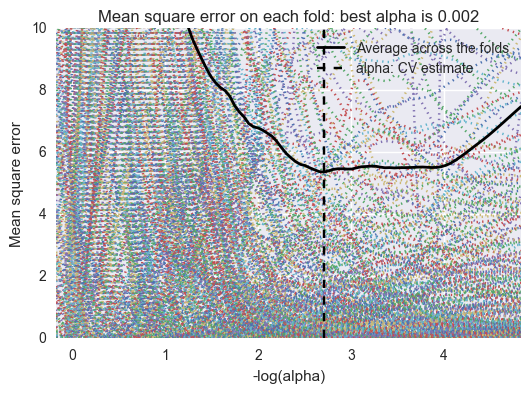

In [16]:
print("Computing regularization path using the coordinate descent lasso...")
n_fold_cv = x_train.shape[0]
model = linear_model.LassoCV(eps=1e-5,n_alphas=100, cv=n_fold_cv).fit(x_train,y_train)
#t_lasso_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
ymin, ymax = 0, 10
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: best alpha is %.3f' %model.alpha_)
plt.axis('tight')
plt.ylim(ymin, ymax)
plt.show()

In [17]:
#coefficients remaining
model.coef_

array([ -5.08424559,   2.38547619,  -5.86292107,   6.93631745,
        -7.77093921,   1.32008159,   0.        ,   5.85547347,
         4.07541055,  -0.        ,   2.28622627,   0.        ,
       -15.83458582,  -0.        ,  23.18581472, -14.747097  ,
        -1.61809527,  -0.        ,  -3.32400401,  -6.95734948,
        -2.11755436,  -4.88895761,   0.89209426,   0.        ,
         0.        ,  -2.67715638,   0.15955442,   3.64653861,
         0.        ,   7.63954058,  19.87964645,  -3.02693696,
        -7.80812825,  -4.18689506,  -1.0856404 ,  -0.        ,
        -6.56312663,  -0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,  -0.        ,  -0.        ,
        -0.60726609,  -0.        ,  -0.        ,   4.13266583,
        -2.88281773, -14.17018296, -12.30659757,  11.93695608,
        -0.        ,   0.        ,   7.07847832,  -0.49310045,
         1.38186543,   1.39743448,   0.62673892, -11.39877068,
         0.        ,  -1.80153078,  -0.        ,   0.67

In [18]:
#get the error
y_hat_test = model.predict(x_test)
err = metrics.mean_squared_error(y_test,y_hat_test)
print ('test mse is : %.2f' %err)

test mse is : 15.75


In [19]:
#remaining features
sfm = feature_selection.SelectFromModel(model, prefit=True)
remaining_features = [list(x_train)[i] for i in sfm.get_support(True)]
print ('The renaming features after lasso selection:')
countries = [x for x in remaining_features if 'country' in x]
print (len(remaining_features))
print ('countries count {0}'.format(len(countries)))

The renaming features after lasso selection:
52
countries count 23


## 17 Visualization 2

## wage gap graph vs year for each country

Total Countries 31
Countries in feature list 23


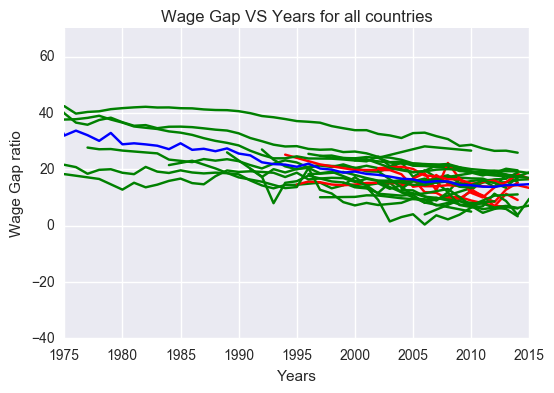

In [20]:
%matplotlib inline
#create x vector
plot_data = data_no_na
years = set(plot_data['Year'])
years=list(years)
country_colums_list = list(x)[0:countries_count]
y_graphs_dict = {}
#split to x axis (years) and y axis(wage gap)
for country in country_colums_list:
     y_vector = plot_data[plot_data[country] == 1]
     y_vector=pd.DataFrame(y_vector, columns = ['Year','WageGaP'])
     y_graphs_dict[country] = y_vector

#add average
aggregated = plot_data.groupby('Year').mean()['WageGaP']
aggregated_wg = aggregated.to_frame(name='WageGaP_Avg')
np_array_gap_average = aggregated_wg['WageGaP_Avg'].values
y_graphs_dict['WageGapAvg'] = np_array_gap_average.tolist()

plt.show()
plot_tuple = ()
feature_countries = [x for x in remaining_features if x.startswith('country')]
print ('Total Countries {0}'.format(len(country_colums_list)))
print ('Countries in feature list {0}'.format(len(feature_countries)))
for country in country_colums_list:
    color = 'r'
    if country in remaining_features:
        color = 'g'
    plot_tuple =  plot_tuple+(y_graphs_dict[country].Year,y_graphs_dict[country].WageGaP,color)

#ploting average in blue color
plot_tuple =  plot_tuple+(years,y_graphs_dict['WageGapAvg'],'b')

for i in range(0,len(plot_tuple),3):
    plt.plot(plot_tuple[i],plot_tuple[i+1],plot_tuple[i+2])

plt.ylabel('Wage Gap ratio')
plt.xlabel('Years')
plt.title('Wage Gap VS Years for all countries')
plt.xlim(1975,2015)
plt.ylim(-40,70)
plt.show()

## 18 Visualization 3 

## test_Prediction vs test_Data 

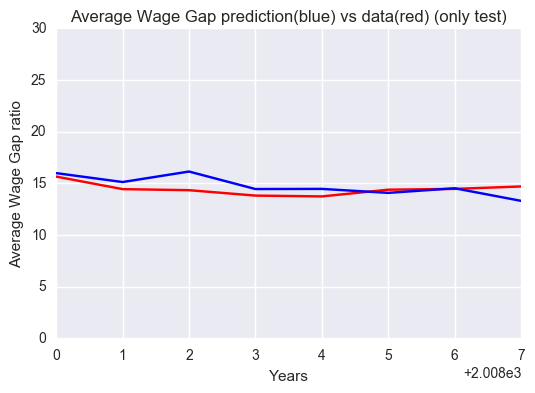

In [21]:
%matplotlib inline

test = data_no_na[data_no_na['Year'] >= traintest_threshold]

plot_data = test[['Year','WageGaP']]
plot_data = plot_data.groupby('Year').mean()

cols = test.columns.tolist()
test_2 = test.reset_index(drop=True)
test_2.columns = cols

df_y_hat = pd.DataFrame(data=y_hat_test,columns=['WageGaPPredict'])

df_prediction = pd.concat([test_2,df_y_hat], axis=1, join='inner')
plot_Prediction = df_prediction[['Year','WageGaPPredict']]
plot_Prediction = plot_Prediction.groupby('Year').mean()

lines = plt.plot(plot_data.index,plot_data.WageGaP,color='r')
lines = plt.plot(plot_Prediction.index,plot_Prediction.WageGaPPredict,color='b')

plt.ylabel('Average Wage Gap ratio')
plt.xlabel('Years')
plt.title('Average Wage Gap prediction(blue) vs data(red) (only test)')
plt.ylim(0,30)
plt.xlim(traintest_threshold,2015)
plt.show()

## 19 Run Model on train and test

In [22]:
y_hat = model.predict(x_normelize)

## 20 Visualize Prediction Vs Data (Train and Test)

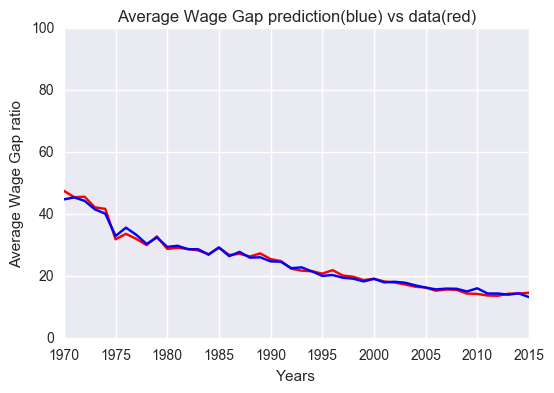

In [23]:
%matplotlib inline

plot_data = data_no_na[['Year','WageGaP']]
plot_data = plot_data.groupby('Year').mean()

# cols = x_normelize.columns.tolist()
# x_normelize_2 = x_normelize.reset_index(drop=True)
# x_normelize_2.columns = cols

df_y_hat = pd.DataFrame(data=y_hat,columns=['WageGaPPredict'])

df_prediction_and_data = pd.concat([data_no_na,df_y_hat], axis=1, join='inner')
plot_Prediction = df_prediction_and_data[['Year','WageGaPPredict']]
plot_Prediction = plot_Prediction.groupby('Year').mean()

lines = plt.plot(plot_data.index,plot_data.WageGaP,color='r')
lines = plt.plot(plot_Prediction.index,plot_Prediction.WageGaPPredict,color='b')

plt.ylabel('Average Wage Gap ratio')
plt.xlabel('Years')
plt.title('Average Wage Gap prediction(blue) vs data(red)')
plt.ylim(0,100)
plt.show()

## 21 Visualize Average Error Precentage

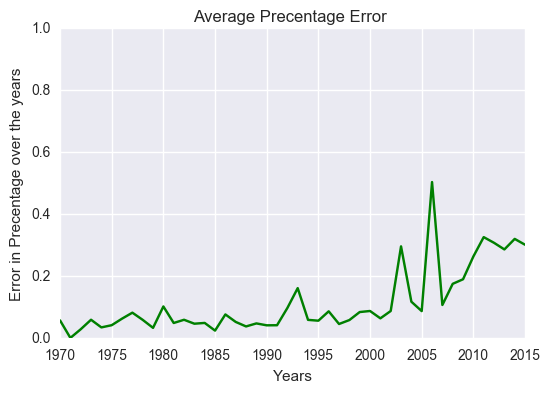

average error in precentage: 0.17


In [24]:
precentage_error_sklearn = (abs(df_prediction_and_data['WageGaPPredict']-df_prediction_and_data['WageGaP'])/df_prediction_and_data['WageGaP'])

df_precentage_error_sklearn = pd.DataFrame(data=precentage_error_sklearn,columns=['PrecentageErr'])

df_prediction_and_data_and_error_sklearn = pd.concat([data_no_na,df_y_hat,df_precentage_error_sklearn], axis=1, join='inner')

plot_precentageErr_sklearn = df_prediction_and_data_and_error_sklearn[['Year','PrecentageErr']]
plot_precentageErr_sklearn = plot_precentageErr_sklearn.groupby('Year').mean()

lines = plt.plot(plot_precentageErr_sklearn.index,plot_precentageErr_sklearn.PrecentageErr,color='g')

plt.ylabel('Error in Precentage over the years')
plt.xlabel('Years')
plt.title('Average Precentage Error ')
plt.ylim(0,1)
plt.show()

err = precentage_error_sklearn.mean()

print('average error in precentage: %.2f' %err)

## 22 Data Modeling (II)

## ML - linear regression using statsmodels

In [25]:
x_train_stats = x_train[remaining_features]

stats_model = sm.OLS(y_train,x_train_stats)
stats_model_results = stats_model.fit()
print(stats_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                WageGaP   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     1159.
Date:                Fri, 06 Jan 2017   Prob (F-statistic):               0.00
Time:                        13:02:52   Log-Likelihood:                -715.43
No. Observations:                 367   AIC:                             1535.
Df Residuals:                     315   BIC:                             1738.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                                                                                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------

In [26]:
x_train_stats = x_test[remaining_features]
y_hat_test_stats = stats_model_results.predict(x_train_stats)
err = metrics.mean_squared_error(y_test,y_hat_test_stats)
print ('statsmodel test mse is : %.2f' %err)

statsmodel test mse is : 18.71


## 23 Visualization statsmodel results

## test_Prediction vs test_Data (statsmodel)

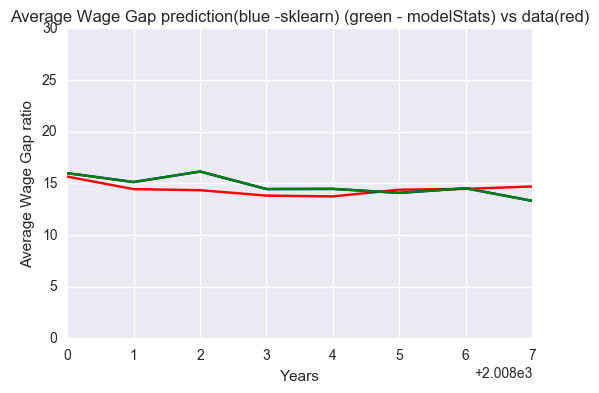

In [27]:
%matplotlib inline

test = data_no_na[data_no_na['Year'] >= traintest_threshold]

plot_data = test[['Year','WageGaP']]
plot_data = plot_data.groupby('Year').mean()

cols = test.columns.tolist()
test_2 = test.reset_index(drop=True)
test_2.columns = cols

df_y_hat_stats = pd.DataFrame(data=y_hat_test_stats,columns=['WageGaPPredict'])

df_prediction_stats = pd.concat([test_2,df_y_hat_stats], axis=1, join='inner')
plot_Prediction_stats = df_prediction_stats[['Year','WageGaPPredict']]
plot_Prediction_stats = plot_Prediction_stats.groupby('Year').mean()

df_y_hat_sklearn = pd.DataFrame(data=y_hat_test,columns=['WageGaPPredict'])

df_prediction_sklearn = pd.concat([test_2,df_y_hat_sklearn], axis=1, join='inner')
plot_Prediction_sklearn = df_prediction_sklearn[['Year','WageGaPPredict']]
plot_Prediction_sklearn = plot_Prediction_sklearn.groupby('Year').mean()

lines = plt.plot(plot_data.index,plot_data.WageGaP,color='r')
lines = plt.plot(plot_Prediction.index,plot_Prediction.WageGaPPredict,color='b')
lines = plt.plot(plot_Prediction_sklearn.index,plot_Prediction_sklearn.WageGaPPredict,color='g')

plt.ylabel('Average Wage Gap ratio')
plt.xlabel('Years')
plt.title('Average Wage Gap prediction(blue -sklearn) (green - modelStats) vs data(red)')
plt.ylim(0,30)
plt.xlim(traintest_threshold,2015)
plt.show()

## 24 Run statsmodels Model on train and test

In [28]:
y_hat_stats = stats_model_results.predict(x_normelize[remaining_features])

## 25 Visualize Prediction Vs Data Train and Test (statsmodels)

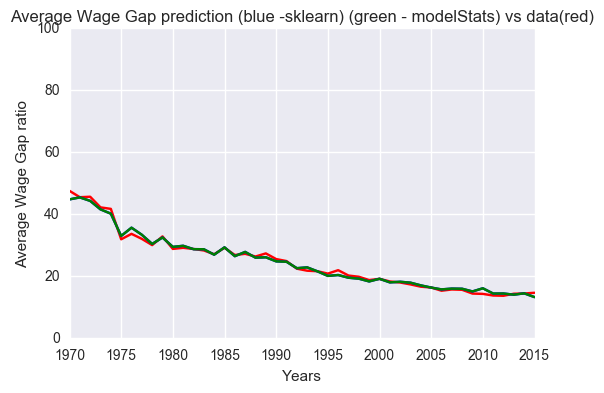

In [29]:
%matplotlib inline

plot_data = data_no_na[['Year','WageGaP']]
plot_data = plot_data.groupby('Year').mean()

# cols = x_normelize.columns.tolist()
# x_normelize_2 = x_normelize.reset_index(drop=True)
# x_normelize_2.columns = cols

df_y_hat_stats = pd.DataFrame(data=y_hat_stats,columns=['WageGaPPredict'])

df_prediction_stats = pd.concat([data_no_na,df_y_hat_stats], axis=1, join='inner')
plot_Prediction_stats = df_prediction_stats[['Year','WageGaPPredict']]
plot_Prediction_stats = plot_Prediction_stats.groupby('Year').mean()

df_y_hat_sklearn = pd.DataFrame(data=y_hat,columns=['WageGaPPredict'])

df_prediction_sklearn = pd.concat([data_no_na,df_y_hat_sklearn], axis=1, join='inner')
plot_Prediction_sklearn = df_prediction_sklearn[['Year','WageGaPPredict']]
plot_Prediction_sklearn = plot_Prediction_sklearn.groupby('Year').mean()

lines = plt.plot(plot_data.index,plot_data.WageGaP,color='r')
lines = plt.plot(plot_Prediction.index,plot_Prediction.WageGaPPredict,color='b')
lines = plt.plot(plot_Prediction_sklearn.index,plot_Prediction_sklearn.WageGaPPredict,color='g')

plt.ylabel('Average Wage Gap ratio')
plt.xlabel('Years')
plt.title('Average Wage Gap prediction (blue -sklearn) (green - modelStats) vs data(red)')
plt.ylim(0,100)
plt.show()

## 26 Average Error Precentage (statsmodels)

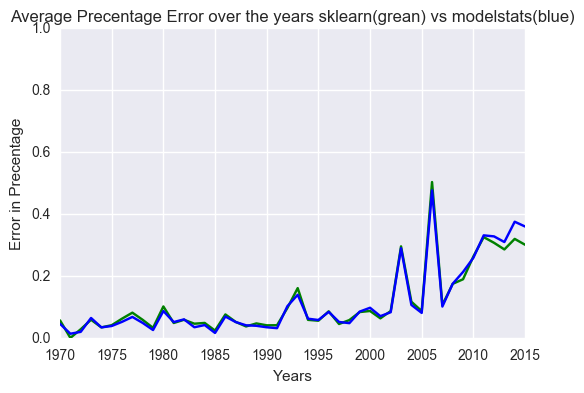

average error using sklearn in precentage: 0.17
average error using modelstatsin precentage: 0.17


In [30]:
precentage_error_stats=(abs(df_prediction_stats['WageGaPPredict']-df_prediction_stats['WageGaP'])/df_prediction_stats['WageGaP'])
precentage_error_sklearn = (abs(df_prediction_sklearn['WageGaPPredict']-df_prediction_sklearn['WageGaP'])/df_prediction_sklearn['WageGaP'])

df_precentage_error_stats = pd.DataFrame(data=precentage_error_stats,columns=['PrecentageErr'])
df_precentage_error_sklearn = pd.DataFrame(data=precentage_error_sklearn,columns=['PrecentageErr'])

df_prediction_and_data_and_error_sklearn = pd.concat([data_no_na,df_y_hat_sklearn,df_precentage_error_sklearn], axis=1, join='inner')
df_prediction_and_data_and_error_stats = pd.concat([data_no_na,df_y_hat_stats,df_precentage_error_stats], axis=1, join='inner')

plot_precentageErr_sklearn = df_prediction_and_data_and_error_sklearn[['Year','PrecentageErr']]
plot_precentageErr_sklearn = plot_precentageErr_sklearn.groupby('Year').mean()

plot_precentageErr_stats = df_prediction_and_data_and_error_stats[['Year','PrecentageErr']]
plot_precentageErr_stats = plot_precentageErr_stats.groupby('Year').mean()


lines = plt.plot(plot_precentageErr_sklearn.index,plot_precentageErr_sklearn.PrecentageErr,color='g')
lines = plt.plot(plot_precentageErr_stats.index,plot_precentageErr_stats.PrecentageErr,color='b')

plt.ylabel('Error in Precentage')
plt.xlabel('Years')
plt.title('Average Precentage Error over the years sklearn(grean) vs modelstats(blue)')
plt.ylim(0,1)
plt.show()

err_mean_stats = precentage_error_stats.mean()
err_mean_sklearn = precentage_error_sklearn.mean()

print('average error using sklearn in precentage: %.2f' %err_mean_stats)
print('average error using modelstatsin precentage: %.2f' %err_mean_sklearn)

## 27 selected features correlations

In [31]:
from pandas.tools.plotting import scatter_matrix

#getting correlation fields code for matrix:
correlation_cols1 = [x for x in remaining_features if 'country' not in x and 'Year' not in x]
full_gender_data = gender_data_raw = pd.read_csv('working_data\GenderStat_Data_new.csv',header=None,skiprows=1)
years_col = list(range(1960,2018))
full_gender_data.columns = ['country-full-name', 'Country Code', 'Indicator Name', 'Indicator Code']+years_col

full_gender_data=full_gender_data.loc[full_gender_data['Indicator Name'].isin(correlation_cols1)]
name_to_code_correlation_df = full_gender_data[['Indicator Name','Indicator Code']].drop_duplicates()

#help df for renaming the indicator code with meaningfull names
temp_data_row= pd.read_csv('name_to_code.csv',header = None,skiprows=1)
temp_data_row.columns = ['index','Indicator Name', 'Indicator Code', 'meaning']

correlation_cols = [x for x in remaining_features if 'country' not in x]+['WageGaP']
features_df = data_no_na[correlation_cols]

#replace the columns names with codes
#create dict old-new
names_dict ={}
for index,row in temp_data_row.iterrows():
    names_dict[row['Indicator Name']] = row['meaning']
    

features_df.rename(columns=names_dict, inplace=True)
#output correlations of 2*2 with wage gap field
for feature in names_dict:
    temp_cols = [names_dict[feature],'WageGaP']
    corr_df = features_df[temp_cols]
    scatter_matrix(corr_df, alpha=0.5, figsize=(6, 6), diagonal='kde')

OSError: File b'name_to_code.csv' does not exist

In [ ]:
print ('Selecting correlation groups manually')
group1 = ['Age dependency','Age population0','Age population1','Age population5','WageGaP']

group2 = ['Adolescent fertility','Fertility rate','Birth rate','Death rate','WageGaP']
group3 = ['Employment ratio f','Employment ratio m','Employment ratio','Employment ratio 24','WageGaP']
group4 = ['GDP','GDP growth','GDP per capita','GNI per capita','GNI, Atlas','WageGaP']
group5 = ['Immunization, measles','Life expectancy f','Life expectancy m','Mortality  infant ','WageGaP']
group6 = ['Labor participation f','Labor participation m','Unemployment, youth female','Unemployment, youth','WageGaP']

#print scatter matrix
corr_df1 = features_df[group1]
scatter_matrix(corr_df1, alpha=0.7, figsize=(11, 11), diagonal='kde')

corr_df2 = features_df[group2]
scatter_matrix(corr_df2, alpha=0.6, figsize=(12, 12), diagonal='kde')

corr_df3 = features_df[group3]
scatter_matrix(corr_df3, alpha=0.6, figsize=(12, 12), diagonal='kde')

corr_df4 = features_df[group4]
scatter_matrix(corr_df4, alpha=0.6, figsize=(12, 12), diagonal='kde')

corr_df5 = features_df[group5]
scatter_matrix(corr_df5, alpha=0.6, figsize=(12, 12), diagonal='kde')

## 28 Searching for a tuple of feature with a product that has a linear correlation to WageGap 

In [36]:
reaminig_features_without_countries = [x for x in remaining_features if not x.startswith("country-full-name")]
x_remaining_features = x_test[reaminig_features_without_countries]
df_y = pd.DataFrame(data_no_na[['WageGaP']],columns=['WageGaP'])
normalized_data_xy = pd.concat([x_remaining_features,df_y], axis=1, join='inner')

df_pearson = pd.DataFrame(columns=['feature_tuple','pearson'])
pearson_index = 0

for i in range(len(reaminig_features_without_countries)):
    for j in range(i+1,len(reaminig_features_without_countries)):
        feat_1 = reaminig_features_without_countries[i]
        feat_2 = reaminig_features_without_countries[j]
        column_name = "{0} * {1}".format(feat_1,feat_2)
        normalized_data_xy[column_name] = normalized_data_xy[feat_1] * normalized_data_xy[feat_2]
        pearson = normalized_data_xy[[column_name,'WageGaP']].corr()
        df_pearson.loc[pearson_index]=[abs(pearson.iloc[0]['WageGaP']),column_name]
        pearson_index = pearson_index +1 

df_pearson.sort_values(['feature_tuple'])
        

,feature_tuple,pearson
66,0.000187,Age dependency ratio (% of working-age populat...
21,0.000343,"Year * Mortality rate, infant (per 1,000 live ..."
340,0.001519,"Immunization, measles (% of children ages 12-2..."
198,0.002036,"Employment to population ratio, 15+, male (%) ..."
371,0.002321,"Life expectancy at birth, female (years) * Mor..."
250,0.002458,"Employment to population ratio, ages 15-24, fe..."
46,0.002738,"Adolescent fertility rate (births per 1,000 wo..."
50,0.002757,"Adolescent fertility rate (births per 1,000 wo..."
386,0.003105,"Mortality rate, infant (per 1,000 live births)..."
300,0.003120,GDP growth (annual%) * Wage and salaried worke...
